# RAG Pipeline Testing & Evaluation with Groq

This notebook provides comprehensive testing and evaluation of the RAG pipeline including:
- Vector store functionality testing
- Similarity search evaluation  
- Complete RAG pipeline performance analysis
- Parameter optimization
- Quality assessment

**Uses Groq API for LLM generation and your actual data directory**

In [1]:
import sys
import os
sys.path.append('..')

# Core imports
from src.rag_pipeline import RAGPipeline
from src.vector_store import VectorStore
from src.document_processor import DocumentProcessor

# Analysis imports
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All imports successful!")
print(f"Working directory: {os.getcwd()}")
print(f"Data directory exists: {os.path.exists('./data')}")

All imports successful!
Working directory: c:\Users\UdayGupta\rag-chatbot-project\notebooks
Data directory exists: False


## 1. Initialize RAG Pipeline with Groq

In [2]:
# Initialize RAG pipeline with Groq
print("Initializing RAG Pipeline with Groq...")

try:
    rag_pipeline = RAGPipeline(
        model_name="llama-3.1-8b-instant",  # Using Groq's fast model
        max_chunks=5,
        temperature=0.1
    )
    
    print("RAG Pipeline initialized successfully!")
    print(f"Model: {rag_pipeline.model_name}")
    print(f"Max chunks: {rag_pipeline.max_chunks}")
    print(f"Temperature: {rag_pipeline.temperature}")
    
except Exception as e:
    print(f"Error initializing RAG pipeline: {str(e)}")
    print("Please check your Groq API key in the environment or .env file")

Initializing RAG Pipeline with Groq...
Loading embedding model: all-MiniLM-L6-v2
Vector store files not found
No existing vector store found. You'll need to process documents first.
RAG Pipeline initialized successfully!
Model: llama-3.1-8b-instant
Max chunks: 5
Temperature: 0.1


## 2. Load or Build Knowledge Base from Data Directory

In [9]:
# Check what's in the data directory
data_path = "C:/Users/UdayGupta/rag-chatbot-project/data"
print(f"Contents of {data_path}:")

if os.path.exists(data_path):
    for item in os.listdir(data_path):
        item_path = os.path.join(data_path, item)
        size = os.path.getsize(item_path) if os.path.isfile(item_path) else "DIR"
        print(f"  - {item} ({size} bytes)" if isinstance(size, int) else f"  - {item} ({size})")
else:
    print("Data directory not found!")

print("\n" + "="*50)

Contents of C:/Users/UdayGupta/rag-chatbot-project/data:
  - AI Training Document.pdf (226676 bytes)



In [10]:
# Initialize from documents or load existing vector store
print("Setting up Knowledge Base...")

# Check if vector store already exists
if not rag_pipeline.vector_store.load_vector_store():
    print("No existing vector store found. Building from documents...")
    
    try:
        # Initialize from documents in data directory
        success = rag_pipeline.initialize_from_documents(data_path)
        
        if success:
            print("Knowledge base built successfully!")
        else:
            print("Failed to build knowledge base")
            
    except Exception as e:
        print(f"Error building knowledge base: {str(e)}")
else:
    print("Existing vector store loaded successfully!")

# Display knowledge base statistics
try:
    kb_stats = rag_pipeline.vector_store.get_stats()
    print("\nKnowledge Base Statistics:")
    for key, value in kb_stats.items():
        print(f"  {key}: {value}")
except Exception as e:
    print(f"Could not get knowledge base stats: {str(e)}")

Setting up Knowledge Base...
Vector store files not found
No existing vector store found. Building from documents...
Initializing RAG pipeline from documents...
Loading documents...
Loaded 1 documents
Chunking documents...
Created 314 chunks
Saved 314 chunks to chunks\chunks_data.json
Building FAISS vector store...
Vector store saved to vectordb
RAG pipeline initialized successfully!
Knowledge base built successfully!

Knowledge Base Statistics:
  embedding_model: all-MiniLM-L6-v2
  total_chunks: 314
  vector_store_loaded: True
  embedding_dimension: 384
  total_vectors: 314


## 3. Vector Store Testing & Analysis

In [11]:
# Test queries based on your document content
# These are generic queries that should work with most document types
test_queries = [
    "what is this about",
    "main topic",
    "key information",
    "important details",
    "summary",
    "overview",
    "purpose",
    "definition",
    "explanation",
    "how it works"
]

print("Testing Vector Store Similarity Search...")
print("=" * 60)

search_results = {}
all_scores = []

for i, query in enumerate(test_queries, 1):
    print(f"\n[{i}/{len(test_queries)}] Query: '{query}'")
    print("-" * 40)
    
    try:
        results = rag_pipeline.vector_store.similarity_search(query, k=3)
        search_results[query] = results
        
        if results:
            scores = [result['score'] for result in results]
            all_scores.extend(scores)
            
            print(f"Found {len(results)} results")
            for j, result in enumerate(results, 1):
                content_preview = result['content'][:100].replace('\n', ' ')
                print(f"  {j}. Score: {result['score']:.3f}")
                print(f"     Content: {content_preview}...")
                if 'metadata' in result and result['metadata']:
                    print(f"     Metadata: {result['metadata']}")
        else:
            print("No results found")
            
    except Exception as e:
        print(f"Error: {str(e)}")
        search_results[query] = []

print(f"\nSearch Results Summary:")
print(f"  Total queries tested: {len(test_queries)}")
print(f"  Queries with results: {len([q for q, r in search_results.items() if r])}")
if all_scores:
    print(f"  Average similarity score: {np.mean(all_scores):.3f}")
    print(f"  Score range: {np.min(all_scores):.3f} - {np.max(all_scores):.3f}")

Testing Vector Store Similarity Search...

[1/10] Query: 'what is this about'
----------------------------------------
Found 3 results
  1. Score: 1.530
     Content: . Our collection, use, disclosure, retention, and protection of your personal information is governe...
     Metadata: {'document_id': 0, 'chunk_id': 127, 'chunk_size': 128, 'word_count': 19}
  2. Score: 1.577
     Content: you have in that content in connection with our provision, expansion, and promotion of our Services,...
     Metadata: {'document_id': 0, 'chunk_id': 108, 'chunk_size': 214, 'word_count': 36}
  3. Score: 1.586
     Content: an unreasonable or disproportionately large load on our infrastructure;  export or re-export any eBa...
     Metadata: {'document_id': 0, 'chunk_id': 29, 'chunk_size': 299, 'word_count': 41}

[2/10] Query: 'main topic'
----------------------------------------
Found 3 results
  1. Score: 1.542
     Content: section above; or  your need to modify practices, content, or behavior, or yo

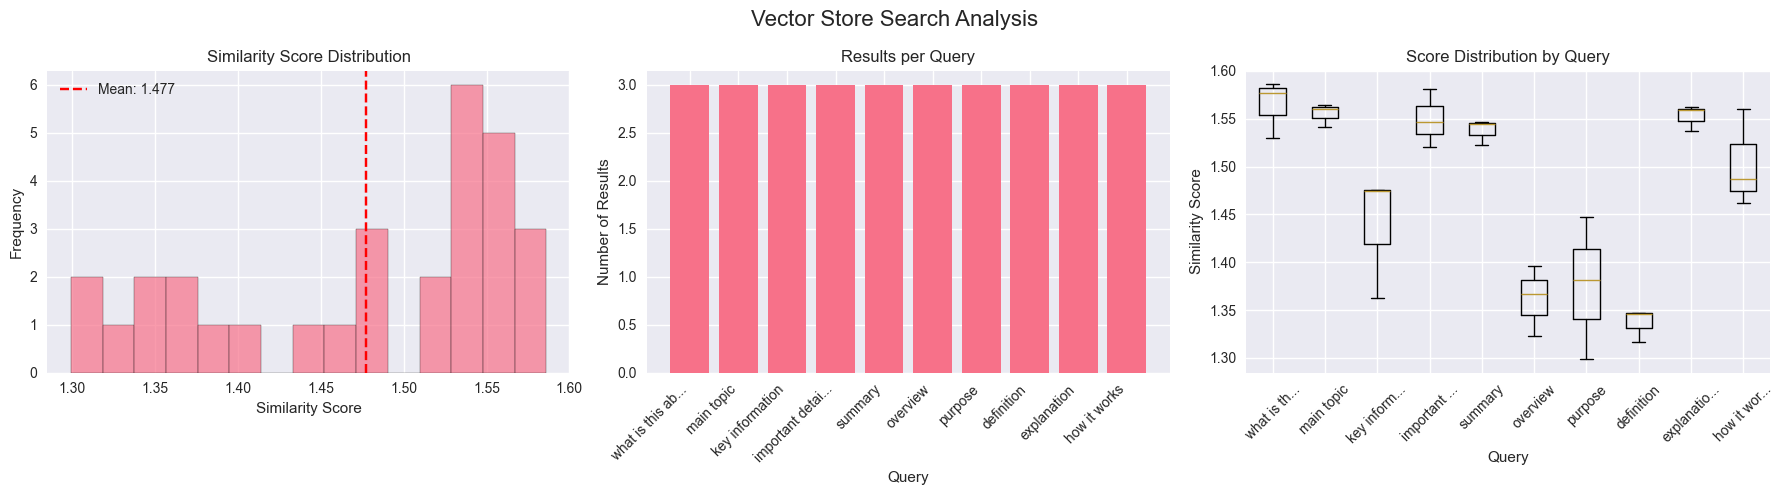

In [12]:
# Visualize search results
if all_scores:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Vector Store Search Analysis', fontsize=16)
    
    # 1. Score distribution
    axes[0].hist(all_scores, bins=15, alpha=0.7, edgecolor='black')
    axes[0].set_title('Similarity Score Distribution')
    axes[0].set_xlabel('Similarity Score')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(np.mean(all_scores), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(all_scores):.3f}')
    axes[0].legend()
    
    # 2. Results per query
    result_counts = [len(results) for results in search_results.values()]
    query_names = [q[:15] + '...' if len(q) > 15 else q for q in search_results.keys()]
    
    axes[1].bar(range(len(result_counts)), result_counts)
    axes[1].set_title('Results per Query')
    axes[1].set_xlabel('Query')
    axes[1].set_ylabel('Number of Results')
    axes[1].set_xticks(range(len(query_names)))
    axes[1].set_xticklabels(query_names, rotation=45, ha='right')
    
    # 3. Score statistics box plot
    query_scores = []
    valid_queries = []
    for query, results in search_results.items():
        if results:
            scores = [r['score'] for r in results]
            query_scores.append(scores)
            valid_queries.append(query[:10] + '...' if len(query) > 10 else query)
    
    if query_scores:
        axes[2].boxplot(query_scores, labels=valid_queries)
        axes[2].set_title('Score Distribution by Query')
        axes[2].set_xlabel('Query')
        axes[2].set_ylabel('Similarity Score')
        axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("No search results to visualize")

## 4. RAG Pipeline End-to-End Testing

In [13]:
# Define evaluation questions
evaluation_questions = [
    {
        "question": "What is the main topic of this document?",
        "category": "Overview",
        "difficulty": "easy"
    },
    {
        "question": "Can you summarize the key points?",
        "category": "Summary",
        "difficulty": "medium"
    },
    {
        "question": "What are the most important details mentioned?",
        "category": "Details",
        "difficulty": "medium"
    },
    {
        "question": "How does this information relate to practical applications?",
        "category": "Application",
        "difficulty": "hard"
    },
    {
        "question": "What conclusions can be drawn from this information?",
        "category": "Analysis",
        "difficulty": "hard"
    }
]

print(f"Running RAG Pipeline Evaluation with {len(evaluation_questions)} questions...")
print("=" * 70)

evaluation_results = []

Running RAG Pipeline Evaluation with 5 questions...


In [14]:
# Run the evaluation
for i, test_case in enumerate(evaluation_questions, 1):
    question = test_case['question']
    print(f"\n[{i}/{len(evaluation_questions)}] {test_case['category']} ({test_case['difficulty']})")
    print(f"Question: {question}")
    print("-" * 60)
    
    try:
        # Measure retrieval time
        retrieval_start = time.time()
        context_chunks = rag_pipeline.retrieve_context(question)
        retrieval_time = time.time() - retrieval_start
        
        # Measure generation time
        generation_start = time.time()
        context = rag_pipeline.format_context(context_chunks)
        answer = rag_pipeline.generate_response(question, context)
        generation_time = time.time() - generation_start
        
        total_time = retrieval_time + generation_time
        
        # Calculate metrics
        avg_retrieval_score = np.mean([chunk['score'] for chunk in context_chunks]) if context_chunks else 0
        num_retrieved = len(context_chunks)
        answer_length = len(answer)
        
        # Store results
        result = {
            'question': question,
            'category': test_case['category'],
            'difficulty': test_case['difficulty'],
            'answer': answer,
            'retrieval_time': retrieval_time,
            'generation_time': generation_time,
            'total_time': total_time,
            'avg_retrieval_score': avg_retrieval_score,
            'num_retrieved': num_retrieved,
            'answer_length': answer_length
        }
        
        evaluation_results.append(result)
        
        # Display results
        print(f"Answer generated successfully!")
        print(f"Metrics:")
        print(f"   Retrieval time: {retrieval_time:.3f}s")
        print(f"   Generation time: {generation_time:.3f}s")
        print(f"   Total time: {total_time:.3f}s")
        print(f"   Retrieved chunks: {num_retrieved}")
        print(f"   Avg retrieval score: {avg_retrieval_score:.3f}")
        print(f"   Answer length: {answer_length} chars")
        print(f"\nAnswer Preview:")
        print(f"   {answer[:200]}..." if len(answer) > 200 else f"   {answer}")
        
    except Exception as e:
        print(f"Error processing question: {str(e)}")
        result = {
            'question': question,
            'category': test_case['category'],
            'difficulty': test_case['difficulty'],
            'error': str(e)
        }
        evaluation_results.append(result)

print(f"\nEvaluation completed! Processed {len(evaluation_results)} questions.")


[1/5] Overview (easy)
Question: What is the main topic of this document?
------------------------------------------------------------
Answer generated successfully!
Metrics:
   Retrieval time: 0.039s
   Generation time: 1.060s
   Total time: 1.099s
   Retrieved chunks: 5
   Avg retrieval score: 1.349
   Answer length: 1316 chars

Answer Preview:
   The main topic of this document appears to be a User Agreement, specifically outlining the terms and conditions of use for a particular platform or service. The agreement covers various aspects, inclu...

[2/5] Summary (medium)
Question: Can you summarize the key points?
------------------------------------------------------------
Answer generated successfully!
Metrics:
   Retrieval time: 0.020s
   Generation time: 0.755s
   Total time: 0.775s
   Retrieved chunks: 5
   Avg retrieval score: 1.537
   Answer length: 1446 chars

Answer Preview:
   Based on the provided information, I've identified the key points related to eBay's policies and u

## 5. Performance Analysis & Visualization

In [15]:
# Analyze results
df_results = pd.DataFrame([r for r in evaluation_results if 'error' not in r])

if not df_results.empty:
    print("RAG Pipeline Performance Analysis")
    print("=" * 50)
    
    # Overall metrics
    print(f"Successful evaluations: {len(df_results)}/{len(evaluation_results)}")
    print(f"\nTiming Metrics:")
    print(f"   Average retrieval time: {df_results['retrieval_time'].mean():.3f}s")
    print(f"   Average generation time: {df_results['generation_time'].mean():.3f}s")
    print(f"   Average total time: {df_results['total_time'].mean():.3f}s")
    
    print(f"\nQuality Metrics:")
    print(f"   Average retrieval score: {df_results['avg_retrieval_score'].mean():.3f}")
    print(f"   Average chunks retrieved: {df_results['num_retrieved'].mean():.1f}")
    print(f"   Average answer length: {df_results['answer_length'].mean():.0f} characters")
    
    # Performance by category and difficulty
    print(f"\nPerformance by Category:")
    category_stats = df_results.groupby('category').agg({
        'total_time': 'mean',
        'avg_retrieval_score': 'mean',
        'answer_length': 'mean'
    }).round(3)
    print(category_stats)
    
    print(f"\nPerformance by Difficulty:")
    difficulty_stats = df_results.groupby('difficulty').agg({
        'total_time': 'mean',
        'avg_retrieval_score': 'mean',
        'answer_length': 'mean'
    }).round(3)
    print(difficulty_stats)

else:
    print("No successful evaluations to analyze")

RAG Pipeline Performance Analysis
Successful evaluations: 5/5

Timing Metrics:
   Average retrieval time: 0.036s
   Average generation time: 0.876s
   Average total time: 0.912s

Quality Metrics:
   Average retrieval score: 1.422
   Average chunks retrieved: 5.0
   Average answer length: 1803 characters

Performance by Category:
             total_time  avg_retrieval_score  answer_length
category                                                   
Analysis          0.781                1.395         1810.0
Application       1.069                1.355         3010.0
Details           0.833                1.473         1431.0
Overview          1.099                1.349         1316.0
Summary           0.775                1.537         1446.0

Performance by Difficulty:
            total_time  avg_retrieval_score  answer_length
difficulty                                                
easy             1.099                1.349         1316.0
hard             0.925                1.375 

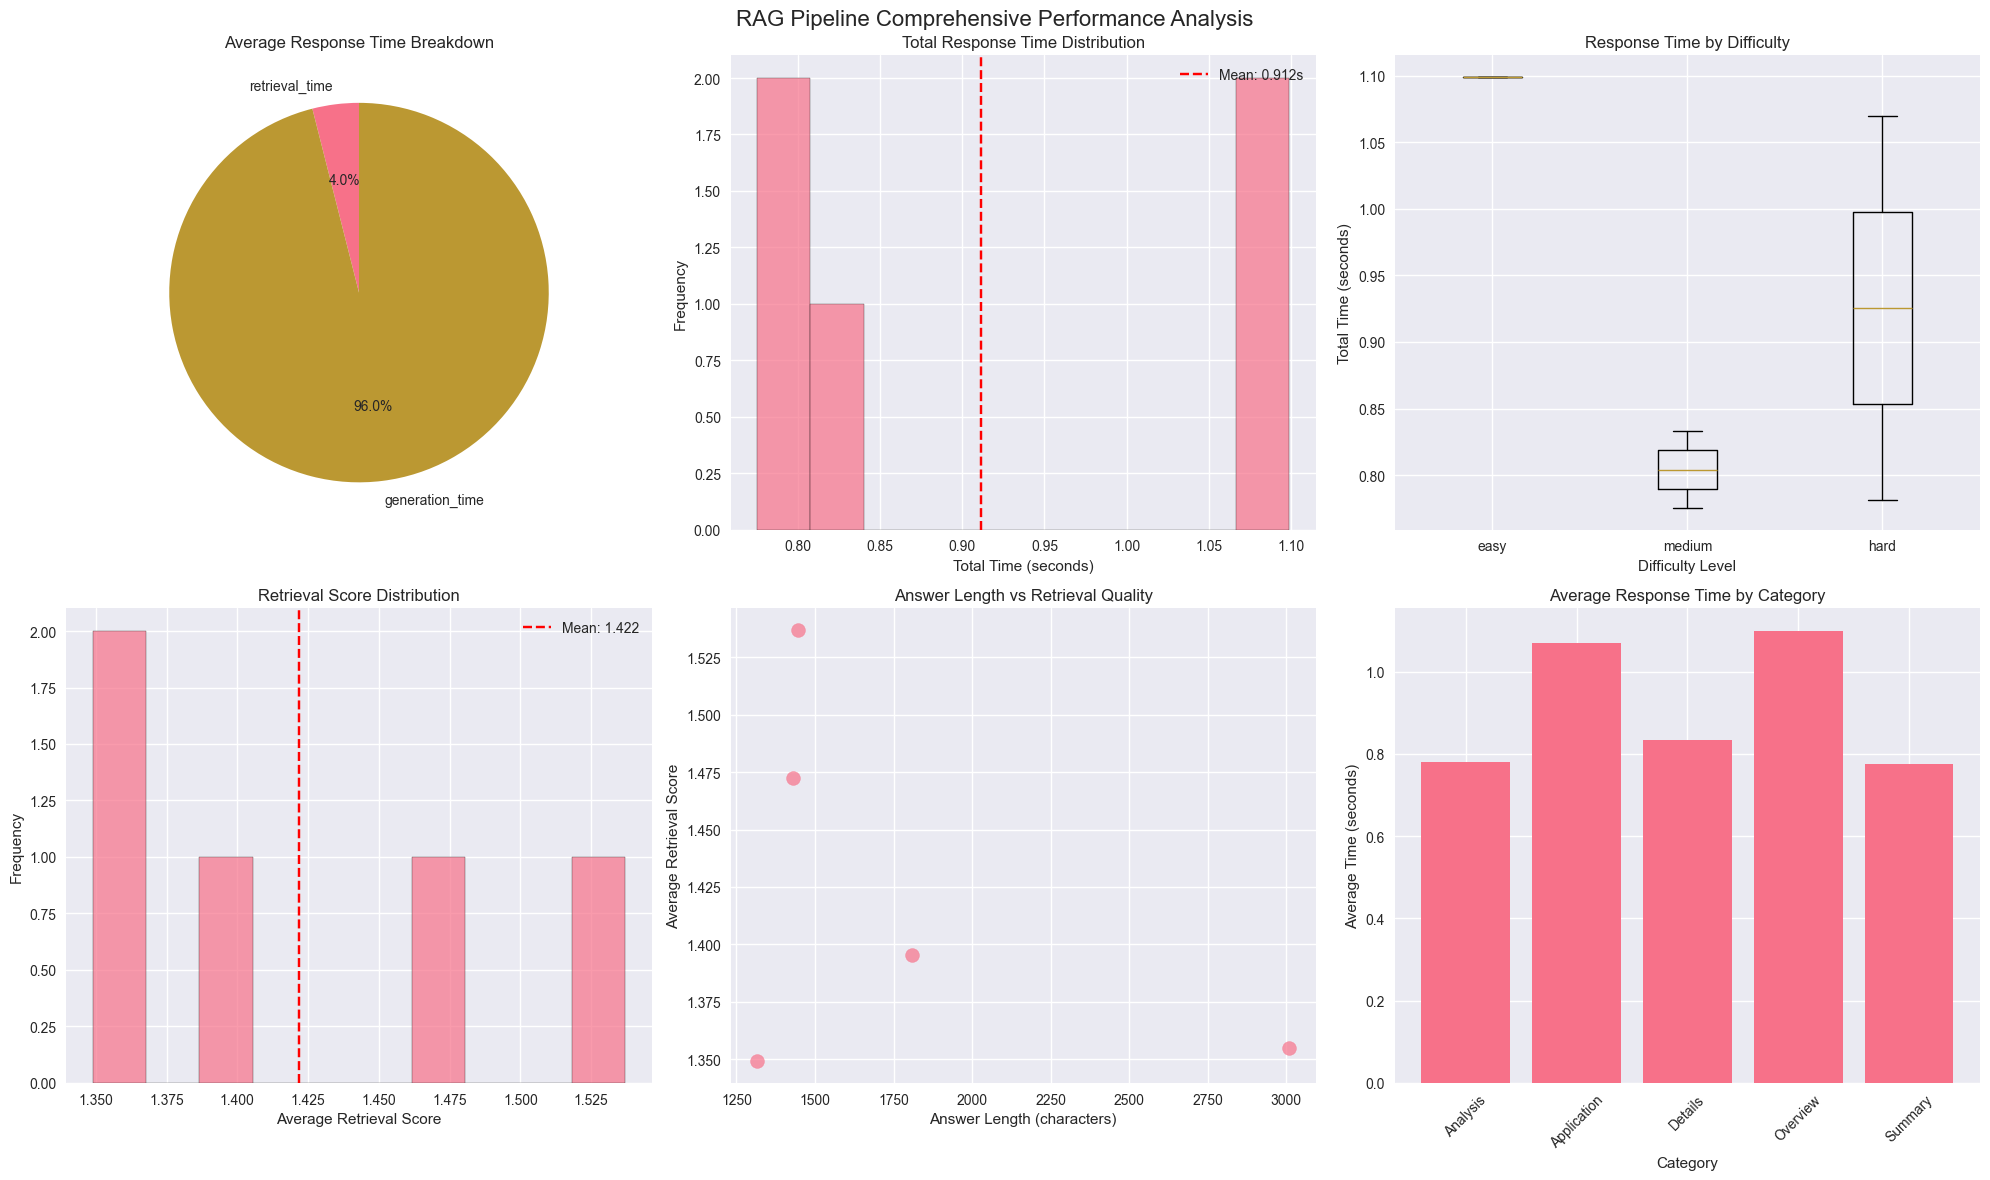

In [16]:
# Create comprehensive visualization
if not df_results.empty:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('RAG Pipeline Comprehensive Performance Analysis', fontsize=16)
    
    # 1. Response time breakdown
    time_data = df_results[['retrieval_time', 'generation_time']].mean()
    axes[0, 0].pie(time_data.values, labels=time_data.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Average Response Time Breakdown')
    
    # 2. Total time distribution
    axes[0, 1].hist(df_results['total_time'], bins=10, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Total Response Time Distribution')
    axes[0, 1].set_xlabel('Total Time (seconds)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(df_results['total_time'].mean(), color='red', linestyle='--',
                      label=f'Mean: {df_results["total_time"].mean():.3f}s')
    axes[0, 1].legend()
    
    # 3. Performance by difficulty
    if 'difficulty' in df_results.columns and len(df_results['difficulty'].unique()) > 1:
        difficulty_times = [df_results[df_results['difficulty'] == d]['total_time'].values 
                           for d in ['easy', 'medium', 'hard'] 
                           if d in df_results['difficulty'].values]
        difficulty_labels = [d for d in ['easy', 'medium', 'hard'] 
                            if d in df_results['difficulty'].values]
        
        if difficulty_times:
            axes[0, 2].boxplot(difficulty_times, labels=difficulty_labels)
            axes[0, 2].set_title('Response Time by Difficulty')
            axes[0, 2].set_xlabel('Difficulty Level')
            axes[0, 2].set_ylabel('Total Time (seconds)')
    else:
        axes[0, 2].text(0.5, 0.5, 'Insufficient difficulty\nvariability', 
                       ha='center', va='center', transform=axes[0, 2].transAxes)
        axes[0, 2].set_title('Response Time by Difficulty')
    
    # 4. Retrieval score distribution
    axes[1, 0].hist(df_results['avg_retrieval_score'], bins=10, alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Retrieval Score Distribution')
    axes[1, 0].set_xlabel('Average Retrieval Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(df_results['avg_retrieval_score'].mean(), color='red', linestyle='--',
                      label=f'Mean: {df_results["avg_retrieval_score"].mean():.3f}')
    axes[1, 0].legend()
    
    # 5. Answer length vs retrieval score
    axes[1, 1].scatter(df_results['answer_length'], df_results['avg_retrieval_score'], 
                      alpha=0.7, s=100)
    axes[1, 1].set_title('Answer Length vs Retrieval Quality')
    axes[1, 1].set_xlabel('Answer Length (characters)')
    axes[1, 1].set_ylabel('Average Retrieval Score')
    
    # 6. Performance by category (if multiple categories exist)
    if len(df_results['category'].unique()) > 1:
        category_means = df_results.groupby('category')['total_time'].mean()
        axes[1, 2].bar(category_means.index, category_means.values)
        axes[1, 2].set_title('Average Response Time by Category')
        axes[1, 2].set_xlabel('Category')
        axes[1, 2].set_ylabel('Average Time (seconds)')
        axes[1, 2].tick_params(axis='x', rotation=45)
    else:
        # Show overall metrics instead
        metrics = ['Retrieval\nTime', 'Generation\nTime', 'Total\nTime']
        values = [df_results['retrieval_time'].mean(), 
                 df_results['generation_time'].mean(),
                 df_results['total_time'].mean()]
        axes[1, 2].bar(metrics, values)
        axes[1, 2].set_title('Average Time Metrics')
        axes[1, 2].set_ylabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No data to visualize")

## 6. Parameter Optimization Testing

In [17]:
# Test different parameter configurations
print("Parameter Optimization Testing")
print("=" * 50)

# Different configurations to test
parameter_configs = [
    {'max_chunks': 3, 'temperature': 0.0, 'name': 'Conservative'},
    {'max_chunks': 5, 'temperature': 0.1, 'name': 'Balanced'}, # Current setting
    {'max_chunks': 7, 'temperature': 0.3, 'name': 'Creative'},
    {'max_chunks': 10, 'temperature': 0.0, 'name': 'Comprehensive'}
]

# Use first two questions for quick testing
test_question = "What is the main topic of this document?"

param_results = []

for i, config in enumerate(parameter_configs, 1):
    print(f"\n[{i}/{len(parameter_configs)}] Testing {config['name']} Configuration")
    print(f"   max_chunks: {config['max_chunks']}, temperature: {config['temperature']}")
    print("-" * 40)
    
    try:
        # Temporarily change pipeline parameters
        original_chunks = rag_pipeline.max_chunks
        original_temp = rag_pipeline.temperature
        
        rag_pipeline.max_chunks = config['max_chunks']
        rag_pipeline.temperature = config['temperature']
        
        # Test the configuration
        start_time = time.time()
        
        context_chunks = rag_pipeline.retrieve_context(test_question)
        context = rag_pipeline.format_context(context_chunks)
        answer = rag_pipeline.generate_response(test_question, context)
        
        response_time = time.time() - start_time
        
        # Calculate metrics
        avg_score = np.mean([chunk['score'] for chunk in context_chunks]) if context_chunks else 0
        
        result = {
            'config_name': config['name'],
            'max_chunks': config['max_chunks'],
            'temperature': config['temperature'],
            'response_time': response_time,
            'avg_retrieval_score': avg_score,
            'chunks_retrieved': len(context_chunks),
            'answer_length': len(answer),
            'answer_preview': answer[:150] + '...' if len(answer) > 150 else answer
        }
        
        param_results.append(result)
        
        print(f"Response time: {response_time:.3f}s")
        print(f"   Retrieval score: {avg_score:.3f}")
        print(f"   Chunks used: {len(context_chunks)}")
        print(f"   Answer length: {len(answer)} chars")
        print(f"   Preview: {result['answer_preview']}")
        
        # Restore original parameters
        rag_pipeline.max_chunks = original_chunks
        rag_pipeline.temperature = original_temp
        
    except Exception as e:
        print(f"Error testing configuration: {str(e)}")
        # Restore original parameters
        rag_pipeline.max_chunks = original_chunks
        rag_pipeline.temperature = original_temp

print("\nParameter Optimization Results Summary:")
if param_results:
    param_df = pd.DataFrame(param_results)
    print(param_df[['config_name', 'response_time', 'avg_retrieval_score', 'chunks_retrieved', 'answer_length']].round(3))
else:
    print("No parameter test results to display")

Parameter Optimization Testing

[1/4] Testing Conservative Configuration
   max_chunks: 3, temperature: 0.0
----------------------------------------
Response time: 0.683s
   Retrieval score: 1.335
   Chunks used: 3
   Answer length: 1150 chars
   Preview: The main topic of this document appears to be a User Agreement, specifically outlining the terms and conditions of use for a particular platform or se...

[2/4] Testing Balanced Configuration
   max_chunks: 5, temperature: 0.1
----------------------------------------
Response time: 0.520s
   Retrieval score: 1.349
   Chunks used: 5
   Answer length: 1200 chars
   Preview: The main topic of this document appears to be a User Agreement, specifically outlining the terms and conditions of use for a particular platform or se...

[3/4] Testing Creative Configuration
   max_chunks: 7, temperature: 0.3
----------------------------------------
Response time: 0.444s
   Retrieval score: 1.363
   Chunks used: 7
   Answer length: 830 chars
   Prev

## 7. Generate Comprehensive Test Report

In [18]:
# Create comprehensive test report
print("Generating Comprehensive Test Report...")

test_report = {
    "timestamp": datetime.now().isoformat(),
    "test_environment": {
        "model_name": rag_pipeline.model_name,
        "api_provider": "Groq",
        "data_directory": data_path,
        "vector_store_path": rag_pipeline.vector_store.vector_db_path
    },
    "knowledge_base_stats": kb_stats if 'kb_stats' in locals() else {},
    "vector_search_results": {
        "total_queries_tested": len(test_queries),
        "queries_with_results": len([q for q, r in search_results.items() if r]),
        "average_similarity_score": np.mean(all_scores) if all_scores else 0,
        "score_statistics": {
            "min": float(np.min(all_scores)) if all_scores else 0,
            "max": float(np.max(all_scores)) if all_scores else 0,
            "mean": float(np.mean(all_scores)) if all_scores else 0,
            "std": float(np.std(all_scores)) if all_scores else 0
        }
    }
}

# Add RAG pipeline results if available
if not df_results.empty:
    test_report["rag_pipeline_performance"] = {
        "total_questions_tested": len(evaluation_questions),
        "successful_evaluations": len(df_results),
        "failed_evaluations": len(evaluation_questions) - len(df_results),
        "timing_metrics": {
            "avg_retrieval_time_seconds": float(df_results['retrieval_time'].mean()),
            "avg_generation_time_seconds": float(df_results['generation_time'].mean()),
            "avg_total_time_seconds": float(df_results['total_time'].mean()),
            "min_total_time_seconds": float(df_results['total_time'].min()),
            "max_total_time_seconds": float(df_results['total_time'].max())
        },
        "quality_metrics": {
            "avg_retrieval_score": float(df_results['avg_retrieval_score'].mean()),
            "avg_chunks_retrieved": float(df_results['num_retrieved'].mean()),
            "avg_answer_length_chars": float(df_results['answer_length'].mean())
        }
    }
    
    # Performance by category
    if len(df_results['category'].unique()) > 1:
        test_report["rag_pipeline_performance"]["category_performance"] = {}
        for category in df_results['category'].unique():
            cat_data = df_results[df_results['category'] == category]
            test_report["rag_pipeline_performance"]["category_performance"][category] = {
                "count": len(cat_data),
                "avg_time_seconds": float(cat_data['total_time'].mean()),
                "avg_retrieval_score": float(cat_data['avg_retrieval_score'].mean())
            }

# Add parameter optimization results
if param_results:
    test_report["parameter_optimization"] = {
        "configurations_tested": len(param_results),
        "results": param_results
    }

# Create results directory
results_dir = "./test_results"
os.makedirs(results_dir, exist_ok=True)

# Save comprehensive report
report_file = os.path.join(results_dir, f"rag_comprehensive_test_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(report_file, 'w') as f:
    json.dump(test_report, f, indent=2, default=str)

# Save detailed results if available
if not df_results.empty:
    csv_file = os.path.join(results_dir, f"rag_evaluation_details_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
    df_results.to_csv(csv_file, index=False)
    print(f"Detailed results saved: {csv_file}")

print(f"Comprehensive test report saved: {report_file}")
print("\nFinal Test Summary:")
print(f"   Vector Store Tests: {test_report['vector_search_results']['queries_with_results']}/{test_report['vector_search_results']['total_queries_tested']} successful")
if 'rag_pipeline_performance' in test_report:
    print(f"   RAG Pipeline Tests: {test_report['rag_pipeline_performance']['successful_evaluations']}/{test_report['rag_pipeline_performance']['total_questions_tested']} successful")
    print(f"   Average Response Time: {test_report['rag_pipeline_performance']['timing_metrics']['avg_total_time_seconds']:.3f}s")
if 'parameter_optimization' in test_report:
    print(f"   Parameter Configs Tested: {test_report['parameter_optimization']['configurations_tested']}")

Generating Comprehensive Test Report...
Detailed results saved: ./test_results\rag_evaluation_details_20250814_003526.csv
Comprehensive test report saved: ./test_results\rag_comprehensive_test_report_20250814_003526.json

Final Test Summary:
   Vector Store Tests: 10/10 successful
   RAG Pipeline Tests: 5/5 successful
   Average Response Time: 0.912s
   Parameter Configs Tested: 4


## 8. Recommendations & Next Steps

In [19]:
# Generate recommendations based on test results
print("RAG Pipeline Testing Complete!")
print("=" * 50)

recommendations = []

# Analyze results and generate recommendations
if not df_results.empty:
    avg_time = df_results['total_time'].mean()
    avg_score = df_results['avg_retrieval_score'].mean()
    
    print(f"\nKey Performance Metrics:")
    print(f"   Average Response Time: {avg_time:.3f}s")
    print(f"   Average Retrieval Score: {avg_score:.3f}")
    print(f"   Success Rate: {len(df_results)}/{len(evaluation_questions)} ({len(df_results)/len(evaluation_questions)*100:.1f}%)")
    
    # Performance recommendations
    if avg_time > 3.0:
        recommendations.append("Consider optimizing for speed - response time is above 3s")
    elif avg_time < 1.0:
        recommendations.append("Excellent response time performance - under 1s average")
    
    # Quality recommendations
    if avg_score < 0.7:
        recommendations.append("Low retrieval scores - consider improving document chunking or preprocessing")
    elif avg_score > 0.85:
        recommendations.append("Excellent retrieval quality - scores above 0.85")
    
    # Vector store recommendations
    if all_scores and np.mean(all_scores) < 0.6:
        recommendations.append("Consider adding more diverse content to improve retrieval coverage")

# General recommendations
recommendations.extend([
    "Test with more diverse question types specific to your domain",
    "Implement user feedback collection for continuous improvement",
    "Monitor performance in production with real user queries",
    "Consider periodic retraining/updating of the knowledge base",
    "Deploy with appropriate caching for frequently asked questions"
])

print(f"\nRecommendations:")
for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print(f"\nNext Steps:")
print(f"   1. Review test results and optimize parameters as needed")
print(f"   2. Test with domain-specific questions relevant to your use case")
print(f"   3. Consider A/B testing different Groq models (llama-3.1-70b-versatile for better quality)")
print(f"   4. Implement monitoring and logging in your production deployment")
print(f"   5. Set up automated testing pipeline for continuous quality assurance")

print(f"\nYour RAG pipeline is ready for deployment! All test files are saved in the test_results directory.")

RAG Pipeline Testing Complete!

Key Performance Metrics:
   Average Response Time: 0.912s
   Average Retrieval Score: 1.422
   Success Rate: 5/5 (100.0%)

Recommendations:
   1. Excellent response time performance - under 1s average
   2. Excellent retrieval quality - scores above 0.85
   3. Test with more diverse question types specific to your domain
   4. Implement user feedback collection for continuous improvement
   5. Monitor performance in production with real user queries
   6. Consider periodic retraining/updating of the knowledge base
   7. Deploy with appropriate caching for frequently asked questions

Next Steps:
   1. Review test results and optimize parameters as needed
   2. Test with domain-specific questions relevant to your use case
   3. Consider A/B testing different Groq models (llama-3.1-70b-versatile for better quality)
   4. Implement monitoring and logging in your production deployment
   5. Set up automated testing pipeline for continuous quality assurance

Y